In [1]:
import numpy as np
import pandas as pd
import numpy
import os, json, csv
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.3.0


# Step 1: Open Tweets.csv & Extract features and labels

# Open CSV files

In [2]:
import numpy as np
import csv

def TweetExtractor(csv_file):

    tweets = []
    labels = []
    with open(csv_file, encoding='utf-8') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        try:
            for index, row in enumerate(csv_reader):
                if index > 0:
                    sentiment = row[1]
                    sentiment_conf = float(row[2])
                    transcript = row[10]
                    if sentiment_conf >= 0.80:
                        tweets.append(transcript)
                        labels.append(sentiment)
                    else:
                        ("low conf")
                    
                else:
                    pass
        except Exception as e:
            print("Exception: {}".format(e))
        
    tweets = np.array(tweets)
    labels = np.array(labels)
    
    return tweets, labels

tweets, labels = TweetExtractor("Tweets.csv")

# Plot label distribution

[7392 1550 1517]
['negative' 'neutral' 'positive']


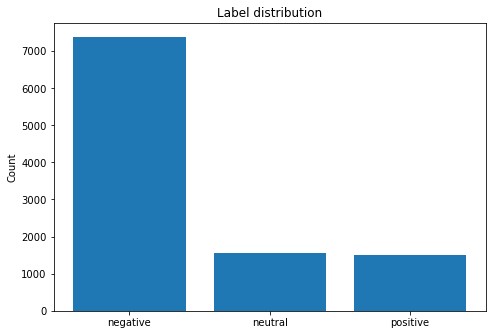

In [3]:
import numpy
label_dist, label_dist_count = numpy.unique(labels, return_counts = True)
label_dist = label_dist.astype("str")

print(label_dist_count)
print(label_dist)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Count')
ax.set_title('Label distribution')
ax.bar(label_dist,label_dist_count)
plt.show()

# Step 2: Remove duplicates

In [4]:
__, index_list, counts = numpy.unique(tweets, return_index=True, return_counts = True, axis = 0)
print("The number of unique idx in X_data_array: {}\n".format(len(index_list)))

The number of unique idx in X_data_array: 10356



In [5]:
unique_training_data = []
unique_training_label = []

for index, (transcript, label) in enumerate(zip(tweets, labels)):
    
    # if index is in index_list
    if index in index_list:
        unique_training_data.append(transcript)
        unique_training_label.append(label)
        
    else:
        pass
    
unique_training_data = numpy.array(unique_training_data)
unique_training_label = numpy.array(unique_training_label)

# Step 3: Clean tweets
- lowercase
- remove punctuations
- remove white spaces

In [6]:
import string
import re 

def processor(X_data_array):
    clean_data_array = []
    for sentence in X_data_array:
        # Lowercase
        sentence = sentence.lower()
        
        # Remove punctuations
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        
        # Remove white spaces
        sentence = re.sub(' +', ' ',sentence).strip()
        
        # Append cleaned sentences
        clean_data_array.append(sentence)

    clean_data_array = numpy.array(clean_data_array)
    return clean_data_array


unique_training_data = processor(unique_training_data)

print("training phrase example after data cleaning: \n{}".format(unique_training_data[1]))

training phrase example after data cleaning: 
virginamerica its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse


# Step 4: Tokenizer and pad text data to sequence

In [7]:
word_dict = {}
for sentence in unique_training_data:
    for word in sentence.split(" "):
        if word not in word_dict:
            word_dict[word] = True

max_sentence_length = 0
for sentence in unique_training_data:
    sentence = sentence.split(" ")
    sentence_len = len(sentence)
    if sentence_len > max_sentence_length:
        max_sentence_length = sentence_len

print("len of total features: {}".format(len(word_dict)))
print("max sentence len: {}".format(max_sentence_length))

len of total features: 13886
max sentence len: 36


# Tokenization

In [8]:
from keras.preprocessing.text import text_to_word_sequence
tokenized_data = []
for sentence in unique_training_data:
    tokens = text_to_word_sequence(sentence)
    tokenized_data.append(tokens)

# pad text data to sequence

In [9]:
vocab_size = len(word_dict)
max_text_length = max_sentence_length
x_tokenizer = text.Tokenizer(num_words=vocab_size)
x_tokenizer.fit_on_texts(tokenized_data)
x_tokenized = x_tokenizer.texts_to_sequences(tokenized_data)
x_train_data = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

# get word index vocab

In [10]:
word_index = x_tokenizer.word_index

# train Word2Vec model (transfer learning)

In [13]:
from gensim.models import Word2Vec

embed_dim = 300
# size option needs to be set to 300 to be the same as Google's pre-trained model
model = Word2Vec(min_count=1, sg = 1, size = embed_dim, compute_loss = True, workers = 4)
 
# assign the vectors to the vocabs that are in Google's pre-trained model and your sentences defined above.
model.build_vocab(tokenized_data)
 
# lockf needs to be set to 1.0 to allow continued training.
model.intersect_word2vec_format('GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)
 
# continue training with you own data
model.train(tokenized_data, total_examples=model.corpus_count, epochs = 10)

(1443801, 1887010)

# create a weight matrix for the Embedding layer

In [14]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))
def get_weight_matrix(embedding, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 300))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = embedding.get(word)
    return weight_matrix

embedding_matrix = get_weight_matrix(w2v, word_index)

c:\users\voice\anaconda3\envs\enable-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


# Checkpoint 

In [15]:
print("shape of X_data_array: {}".format(x_train_data.shape))

shape of X_data_array: (10356, 36)


# Plot label distribution

[7326 1539 1491]
['negative' 'neutral' 'positive']


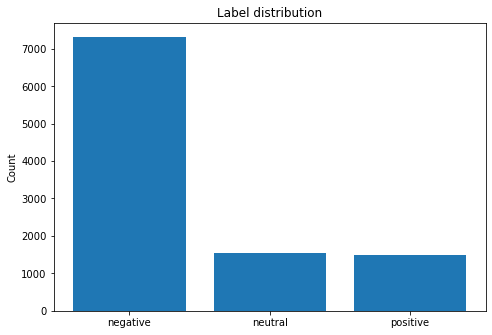

In [16]:
label_dist, label_dist_count = numpy.unique(unique_training_label, return_counts = True)
label_dist = label_dist.astype("str")

print(label_dist_count)
print(label_dist)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Count')
ax.set_title('Label distribution')
ax.bar(label_dist,label_dist_count)
plt.show()

# Binarize labels and one hot encode

In [17]:
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# define example
data = unique_training_label
values = array(data)
# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
#print(integer_encoded)
# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)
Y_data_encoded = onehot_encoded

# Step 5: Split data in train and test

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_data, Y_data_encoded, test_size = 0.20, random_state = 1, stratify=Y_data_encoded)

# Create the Embedding Layer

In [56]:
embedding_dim = 300
model_lstm = Sequential()
#create a embedding layer using pre trained word2vec model
model_lstm.add(Embedding(len(word_index) + 1,
                         embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_text_length,
                         trainable=False))
model_lstm.add(Dropout(0.4))

# Build model

In [57]:
model_lstm.add(Bidirectional(LSTM(embedding_dim)))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(600, activation="relu"))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(3, activation="softmax"))
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 36, 300)           4144500   
_________________________________________________________________
dropout_16 (Dropout)         (None, 36, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 600)               1442400   
_________________________________________________________________
dropout_17 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 600)               360600    
_________________________________________________________________
dropout_18 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                

# Train model

In [58]:
from keras.optimizers import Adam
model_lstm.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history_lstm = model_lstm.fit(x_train,y_train,batch_size = 32, epochs = 20, validation_data = (x_val, y_val))

Epoch 1/20
259/259 [==============================] - 6s 25ms/step - loss: 0.5910 - accuracy: 0.7688 - val_loss: 0.3623 - val_accuracy: 0.8687
Epoch 2/20
259/259 [==============================] - 5s 21ms/step - loss: 0.3861 - accuracy: 0.8568 - val_loss: 0.3368 - val_accuracy: 0.8808
Epoch 3/20
259/259 [==============================] - 5s 21ms/step - loss: 0.3565 - accuracy: 0.8697 - val_loss: 0.3166 - val_accuracy: 0.8875
Epoch 4/20
259/259 [==============================] - 5s 21ms/step - loss: 0.3466 - accuracy: 0.8723 - val_loss: 0.2994 - val_accuracy: 0.8948
Epoch 5/20
259/259 [==============================] - 5s 21ms/step - loss: 0.3319 - accuracy: 0.8769 - val_loss: 0.3020 - val_accuracy: 0.8890
Epoch 6/20
259/259 [==============================] - 5s 21ms/step - loss: 0.3297 - accuracy: 0.8810 - val_loss: 0.2968 - val_accuracy: 0.8919
Epoch 7/20
259/259 [==============================] - 5s 21ms/step - loss: 0.3274 - accuracy: 0.8807 - val_loss: 0.3014 - val_accuracy: 0.8914

# Plot loss and accuracy

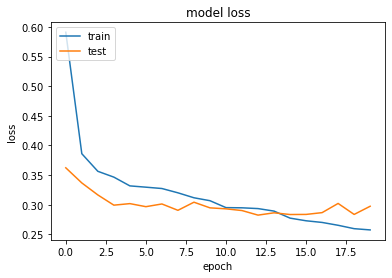

In [59]:
import matplotlib.pyplot as plt
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

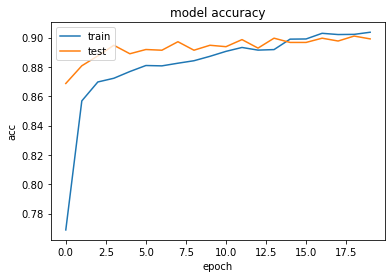

In [60]:
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Confusion matrix

In [61]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model_lstm.predict(x_val)

conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(conf_matrix)
print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))
print()
print(accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)))

[[1418   38   10]
 [  82  212   14]
 [  47   18  233]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1466
           1       0.79      0.69      0.74       308
           2       0.91      0.78      0.84       298

    accuracy                           0.90      2072
   macro avg       0.87      0.81      0.84      2072
weighted avg       0.90      0.90      0.90      2072


0.8991312741312741


# Transformer model

In [41]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import layers

# Multi Head Self Attention

In [62]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

# Transformer block as a layer

In [63]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Build transformer model

In [64]:
num_heads = 4  # Number of attention heads
ff_dim = 64  # Hidden layer size in feed forward network inside transformer

model_transformer = Sequential()
# map vocab index into embedding dimensions
model_transformer.add(Embedding(len(word_index) + 1,
                         embedding_dim,
                         weights=[embedding_matrix],
                         input_length=max_text_length,
                         trainable=False))

model_transformer.add(Dropout(0.2))
model_transformer.add(TransformerBlock(300, num_heads, ff_dim))
model_transformer.add(GlobalMaxPooling1D())
model_transformer.add(Dropout(0.2))
model_transformer.add(Dense(300, activation="relu"))
model_transformer.add(Dropout(0.2))
model_transformer.add(Dense(3, activation="softmax"))
model_transformer.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 36, 300)           4144500   
_________________________________________________________________
dropout_19 (Dropout)         (None, 36, 300)           0         
_________________________________________________________________
transformer_block_2 (Transfo (None, 36, 300)           401164    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 300)               0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_23 (Dropout)         (None, 300)              

# Train model

In [65]:
from keras.optimizers import Adam
model_transformer.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=['accuracy'])
history_transformer = model_transformer.fit(x_train,y_train,batch_size = 32, epochs = 50, validation_data = (x_val, y_val))

Epoch 1/50
259/259 [==============================] - 5s 17ms/step - loss: 0.7648 - accuracy: 0.7209 - val_loss: 0.4235 - val_accuracy: 0.8456
Epoch 2/50
259/259 [==============================] - 4s 16ms/step - loss: 0.4659 - accuracy: 0.8281 - val_loss: 0.3614 - val_accuracy: 0.8649
Epoch 3/50
259/259 [==============================] - 4s 16ms/step - loss: 0.3983 - accuracy: 0.8566 - val_loss: 0.3317 - val_accuracy: 0.8784
Epoch 4/50
259/259 [==============================] - 4s 16ms/step - loss: 0.3599 - accuracy: 0.8702 - val_loss: 0.3171 - val_accuracy: 0.8847
Epoch 5/50
259/259 [==============================] - 4s 16ms/step - loss: 0.3379 - accuracy: 0.8776 - val_loss: 0.3160 - val_accuracy: 0.8880
Epoch 6/50
259/259 [==============================] - 4s 16ms/step - loss: 0.3307 - accuracy: 0.8824 - val_loss: 0.3234 - val_accuracy: 0.8837
Epoch 7/50
259/259 [==============================] - 4s 16ms/step - loss: 0.3198 - accuracy: 0.8838 - val_loss: 0.2952 - val_accuracy: 0.8943

# Plot loss and accuracy

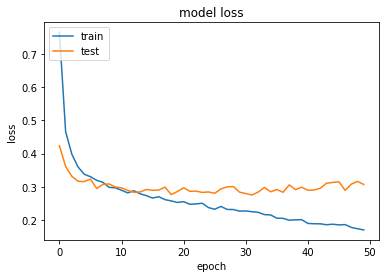

In [66]:
import matplotlib.pyplot as plt
plt.plot(history_transformer.history['loss'])
plt.plot(history_transformer.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

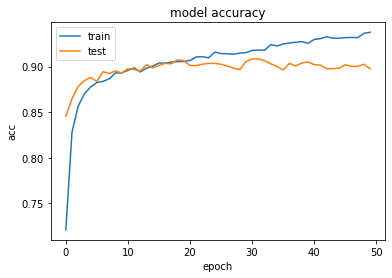

In [67]:
plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Confusion matrix

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = model_lstm.predict(x_val)

conf_matrix = confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1))
print(conf_matrix)
print(classification_report(y_val.argmax(axis=1), y_pred.argmax(axis=1)))
print()
print(accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1)))

[[1418   38   10]
 [  82  212   14]
 [  47   18  233]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1466
           1       0.79      0.69      0.74       308
           2       0.91      0.78      0.84       298

    accuracy                           0.90      2072
   macro avg       0.87      0.81      0.84      2072
weighted avg       0.90      0.90      0.90      2072


0.8991312741312741
